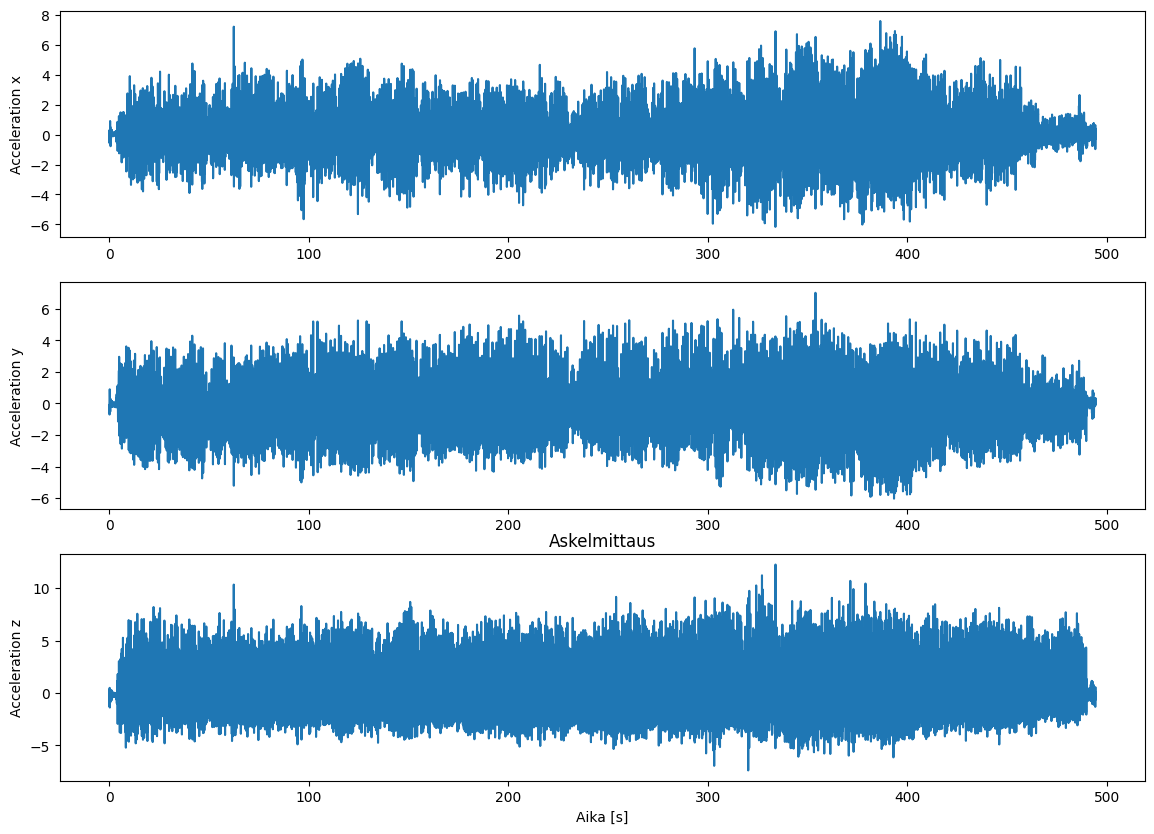

In [10]:

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

# Tarkastellaan lineaarisen kiihtyvyyden x, y, z komponenttien dataa ja valitaan kuvaajien perusteella sopiva komponentti kävelyliikkeen havainnointiin


df = pd.read_csv('./My Experiment1/Linear Acceleration.csv')

plt.figure(figsize=(14,10))
plt.subplot(3,1,1)
plt.plot(df['Time (s)'],df['Linear Acceleration x (m/s^2)'])
plt.ylabel('Acceleration x')
plt.subplot(3,1,2)
plt.plot(df['Time (s)'],df['Linear Acceleration y (m/s^2)'])
plt.ylabel('Acceleration y')
plt.subplot(3,1,3)
plt.plot(df['Time (s)'],df['Linear Acceleration z (m/s^2)'])
plt.ylabel('Acceleration z')
plt.title('Askelmittaus')
plt.xlabel('Aika [s]')
plt.show()


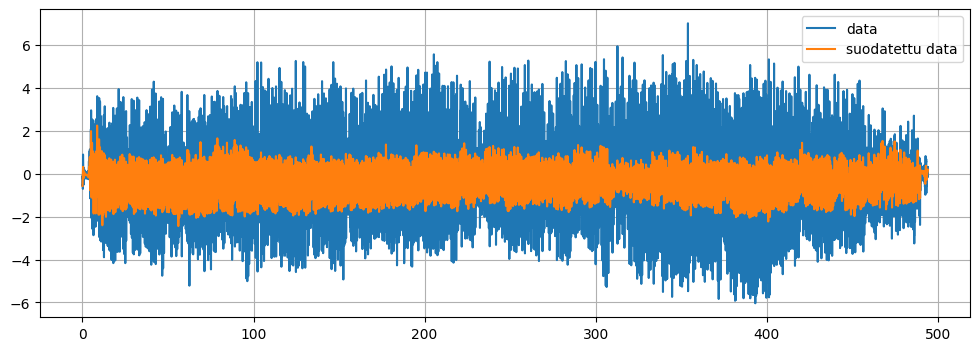

Askelten määrä on 902.5


In [11]:
# Lasketaan askelten määrä suodatetusta datasta 

#Tuodaan filtterifunktiot. Jos scipy puuttuu: pip install scipy
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, nyq, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cutoff,  nyq, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

data = df['Linear Acceleration y (m/s^2)']
T_tot = df['Time (s)'].max() #Koko datan pituus
n = len(df['Time (s)']) #Datapisteiden lukumäärä
fs = n/T_tot #Näytteenottotaajus, OLETETAAN VAKIOKSI
nyq = fs/2 #Nyqvistin taajuus, suurin taajuus, joka datasta voidaan havaita
order = 3
cutoff = 1/0.4 #Cut-off taajuus, tätä suuremmat taajuuden alipäästösuodatin poistaa datasta
#Cut-off -taajuuden tulee olla riittävän pieni, jotta data yleensäkin suodattuu
#Cut-off -taajuuden ei tule olla niin pieni, että se suodattaisi pois askelia
data_filt = butter_lowpass_filter(data, cutoff, nyq, order)

#Piirretään kuvaa, jossa alkuperäinen ja suodatettu signaali
plt.figure(figsize=(12,4))
plt.plot(df['Time (s)'],data,label = 'data')
plt.plot(df['Time (s)'],data_filt,label = 'suodatettu data')
#plt.axis([0,8,-3,3])
plt.grid()
plt.legend()
plt.show()

# lasketaan askelten määrä suodatusta datasta

jaksot = 0
for i in range(n-1):
    if data_filt[i]/data_filt[i+1] < 0:
        jaksot = jaksot + 1/2
print(f'Askelten määrä on {jaksot}')

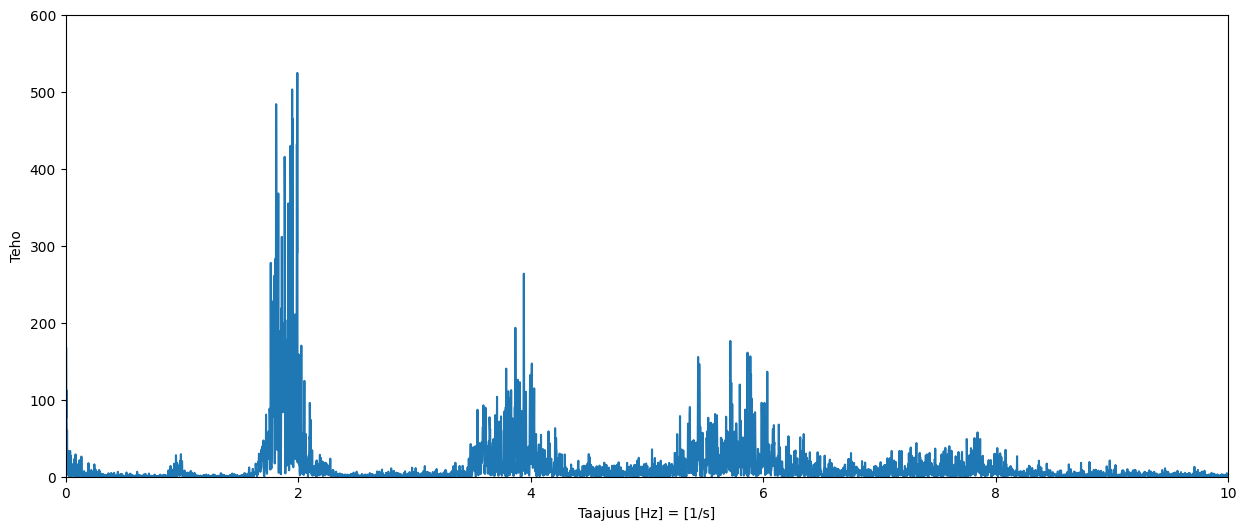

In [12]:

signal = df['Linear Acceleration y (m/s^2)'] # valitaan y komponentti tarkeasteluun
t = df['Time (s)'] #Aika 
N = len(signal) #Havaintojen määrä
dt = np.max(t)/N #Näytteenottoväli (oletetaan vakioksi)

#Fourier-analyysi 
fourier = np.fft.fft(signal,N) #Fourier-muunnos
psd = fourier*np.conj(fourier)/N #Tehospektri
freq = np.fft.fftfreq(N,dt) #Taajuudet
L = np.arange(1,int(N/2)) #Negatiivisten ja nollataajuuksien rajaus

plt.figure(figsize=(15,6))
plt.plot(freq[L],psd[L].real)
plt.xlabel('Taajuus [Hz] = [1/s]')
plt.ylabel('Teho')
plt.axis([0,10,0,600])
plt.show()

In [13]:
 # Lasketaan askelten määrä askeltaajuuden perusteella
f_max = freq[L][psd[L] == np.max(psd[L])][0] #Kävelymittauksen kiihtyvyyyden z-komponentin tehospektrin suurinta tehoa vastaava taajuus. 
#Eli toisinsanoen askelluksen dominoiva taajuus.
T = 1/f_max #Askeleeseen kuluva aika, eli jaksonaika (oletettaen, että dominoiva taajuus on askeltaajuus)
steps =  f_max*np.max(t) #Askelmäärä

print(f'Dominoiva askeltaajuus on {f_max} Hz')
print(f'Tätä vastaava jaksonaika (askelaika) on {T} s' )
print('Askelmäärä tällöin ', np.round(steps) )

Dominoiva askeltaajuus on 1.9929460619017978 Hz
Tätä vastaava jaksonaika (askelaika) on 0.5017697262944163 s
Askelmäärä tällöin  985.0


In [14]:
# Ladataan GPS data 

import pandas as pd
import folium

df = pd.read_csv('./My Experiment1/Location.csv')

df.head()

df = df[df['Horizontal Accuracy (m)'] > 10]
df = df.reset_index(drop =True)

#Määritellään "karttapohja", eli kartan keskipiste
lat1 = df['Latitude (°)'].mean() #Latitudin keskiarvo
long1 = df['Longitude (°)'].mean() #Longitudin keskiarvo

#luodaan kartta
my_map = folium.Map(location = [lat1,long1], zoom_start=15)

#Piirretään reitti kartalle:
folium.PolyLine(df[['Latitude (°)','Longitude (°)']], color = 'red', weight = 3).add_to(my_map)
my_map.save('Kartta_19.11.2025.html')

In [ ]:
# Lasketaan 